# Surge in Jupyter

This notebook shows how to run the surge engine with the python bindings. 
As of this writing, it serves as the full documentation for the Surge<->Python
bindings.

This document assumes that
1. You basically understand how Surge works as a synth. Concepts like
   scenes, oscilaltors, modulators etc
2. You can build surge from source succesfully as outlined in the README and
3. You can manage a python environment with custom modules
4. You are running on a machine where the Surge synth is installed (namely
   the factory data directory is present in an OS specific places as described
   in the manual)

To use the bindings you need to build the Surge python bindings, which are an
off-by-default target. To turn the target on use the CMake argument
`-DBUILD_SURGE_PYTHON_BINDINGS=TRUE`

A sample build would be

```
cd surge
cmake -Bbuildpy -DBUILD_SURGE_PYTHON_BINDINGS=TRUE -DCMAKE_BUILD_TYPE=Release
cmake --build buildpy --config Release --target surgepy
```

which will create the appropriately named `surgepy....so` in `buildpy`. On
macos, for instance, it creates `surgepy.cpython-38-darwin.so`.

You then need that in a place where python3 can see it. Lots of ways to do that. Your
environment has a way. One easy way is `cd buildpy && python3` which will run
python3 in the same directory as the shared library. 

You can run this notebook by `cd buildpy; jupyter notebook` after copying this notebook
into your buildpy too for instance. But if you are reading this you know how to manage
a pythyon environment. So onwards.


All the functions are in the `surgepy`. Lets import it along with matplotlib numpy and a few others

In [1]:
import surgepy

%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import time


## Getting Started

We can confirm the library is working by asking it for a version. This is the same
version string that appears on the about screen of the plugin.

In [2]:
surgepy.getVersion()

'1.8.pybind.016f066a'

Now lets create a surge engine. When we create a surge engine we have to provide
a sample rate. If you try to create surges with two sample rates in one process,
most likely bad things will happen. We use 44.1k here.

In [3]:
surge = surgepy.createSurge( 44100 )

Super. So now lets go ahead and make surge make some sound. As of this writing
the Sure API supports several primitives to do this.
- `process` makes surge calculate a block of output. The block size is `surge.getBlockSize()`
- `playNote` plays a note on channel with velocity and detune
- `releaseNote` releases a note on channel
- `getOutput` returns a 2xBLOCK_SIZE numpy array with the most recent block

Using that we can glom together some samples generated by playing middle C. 
Note the `numpy.append` API here is pretty inefficient. We show a more efficient
approach below. But it will show us the default surge saw wave patch is playing

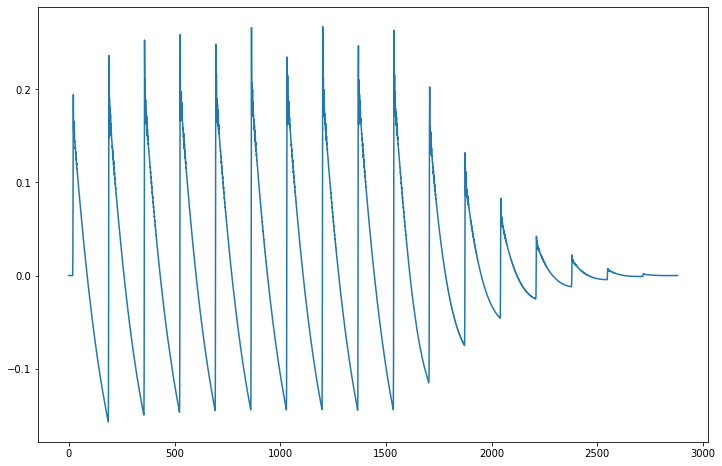

In [4]:
def playQuickC(surge):
    for i in range(10):
        surge.process()
    
    surge.playNote( 0, 60, 127, 0 )
    wave = np.array(0)

    for i in range(50):
        surge.process()
        # this is very inefficient of course
        wave = np.append( wave, surge.getOutput()[0,:])
    
    surge.releaseNote( 0, 60, 0 )

    for i in range(40):
        surge.process()
        wave = np.append( wave, surge.getOutput()[0,:])
        
    for i in range(40): 
        surge.process()  # ring down
    return wave
    
wave = playQuickC(surge)
plt.plot(wave)

## Interacting with values in Surge

A surge patch is a collection of values expressed as parameters which contain
a type, min, max, default value and runtime value. These parameter belong to 
the surge synthesizer and are indexed by an opaque ID class.

To organize these types, Surge has a couple of parameter organization models. In the
C++ code you will see the SurgePatch class a lot, which is very granular and named. We
may expose it in the future. But at runtime, the parameters form a hierarchy where each
parameter belongs to one of a few control groups (OSC, FX, etc...) and inside that control
group, a cluster of parameter have a control group entry. So the OSC control group
in Surge 1.8 has 6 entries, for each of the 3 oscillators in each of the three scenes.

The module 'surgepy.constants' contains constants we can use to look up these control
groups. Lets start by importing it with an alias `sgco` and using that to look up a
control group for oscillators

In [5]:
import surgepy.constants as srgco

cg_OSC = surge.getControlGroup( srgco.cg_OSC )
cg_OSC

<SurgeControlGroup cg=2, cg_OSC>

A control gorup contains a set of entries; and those entries contain a set of parameters.
The synthesizer handed one of those parameters can answer questions about its type
and ranges

In [6]:
oscEnts = cg_OSC.getEntries()
print( oscEnts )
osc0Pars = oscEnts[0].getParams()
print( osc0Pars )

[<SurgeControlGroupEntry entry=0/sceneA in cg_OSC>, <SurgeControlGroupEntry entry=0/sceneB in cg_OSC>, <SurgeControlGroupEntry entry=1/sceneA in cg_OSC>, <SurgeControlGroupEntry entry=1/sceneB in cg_OSC>, <SurgeControlGroupEntry entry=2/sceneA in cg_OSC>, <SurgeControlGroupEntry entry=2/sceneB in cg_OSC>]
[<SurgeNamedParam 'Osc 1 Type'>, <SurgeNamedParam 'Osc 1 Octave'>, <SurgeNamedParam 'Osc 1 Pitch'>, <SurgeNamedParam 'Osc 1 Shape'>, <SurgeNamedParam 'Osc 1 Width 1'>, <SurgeNamedParam 'Osc 1 Width 2'>, <SurgeNamedParam 'Osc 1 Sub Mix'>, <SurgeNamedParam 'Osc 1 Sync'>, <SurgeNamedParam 'Osc 1 Unison Detune'>, <SurgeNamedParam 'Osc 1 Unison Voices'>, <SurgeNamedParam 'Osc 1 Keytrack'>, <SurgeNamedParam 'Osc 1 Retrigger'>]


In [7]:
r = []
for par in osc0Pars:
    par
    r.append( [ par, 
      surge.getParamMin( par ), 
      surge.getParamMax( par ), 
      surge.getParamDef( par ), 
      surge.getParamVal( par ),
      surge.getParamValType( par )
    ])
r

[[<SurgeNamedParam 'Osc 1 Type'>, 0.0, 7.0, 0.0, 0.0, 'int'],
 [<SurgeNamedParam 'Osc 1 Octave'>, -3.0, 3.0, 0.0, 0.0, 'int'],
 [<SurgeNamedParam 'Osc 1 Pitch'>, -7.0, 7.0, 0.0, 0.0, 'float'],
 [<SurgeNamedParam 'Osc 1 Shape'>, -1.0, 1.0, 0.0, 0.0, 'float'],
 [<SurgeNamedParam 'Osc 1 Width 1'>, 0.0, 1.0, 0.5, 0.5, 'float'],
 [<SurgeNamedParam 'Osc 1 Width 2'>, 0.0, 1.0, 0.5, 0.5, 'float'],
 [<SurgeNamedParam 'Osc 1 Sub Mix'>, 0.0, 1.0, 0.0, 0.0, 'float'],
 [<SurgeNamedParam 'Osc 1 Sync'>, 0.0, 60.0, 0.0, 0.0, 'float'],
 [<SurgeNamedParam 'Osc 1 Unison Detune'>,
  0.0,
  1.0,
  0.20000000298023224,
  0.20000000298023224,
  'float'],
 [<SurgeNamedParam 'Osc 1 Unison Voices'>, 1.0, 16.0, 1.0, 1.0, 'int'],
 [<SurgeNamedParam 'Osc 1 Keytrack'>, 0.0, 1.0, 0.0, 1.0, 'bool'],
 [<SurgeNamedParam 'Osc 1 Retrigger'>, 0.0, 1.0, 0.0, 0.0, 'bool']]

If you run the surge VST and move the shape param to -0.9 you will see it turns the
classic oscillator saw into a more square shape. We can do the same here and will
get a square wave output

Shape param:  <SurgeNamedParam 'Osc 1 Shape'>


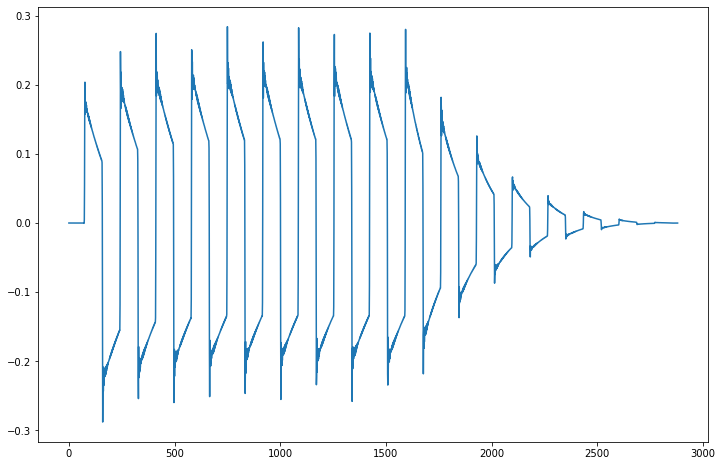

In [8]:
shape = osc0Pars[3];
print( "Shape param: ", shape )
surge.setParamVal(shape, -0.9 )


wave = playQuickC( surge ) 
plt.plot(wave)

Finally, lets define a function which plays surge for about 4 seconds, with
a key relese at second 3, and returns a smoothed RMS of the output. At this point
it should be clear how to do that.

In [9]:
from numpy import mean, sqrt, square

def fourSecondsRMS( surge ):
    samples = 44100 * 4  # 4 seconds
    iterations = int( samples / surge.getBlockSize() / 4 )

    surge.process()
    surge.playNote( 0, 60, 127, 0 )
    surge.process()

    rmsData = []
    for i in range(3 * iterations):
        surge.process()
        rmsData.append(  sqrt( mean( square( surge.getOutput() ))) )
        
    surge.releaseNote( 0, 60, 0 )
    for i in range(iterations):
        surge.process()
        rmsData.append(  sqrt( mean( square( surge.getOutput() ))) )
    
    N = 50
    window = np.convolve(rmsData, np.ones(N)/N, mode='valid')
    return window

And we can now use that to configure a classic ADSR envelope on a new surge

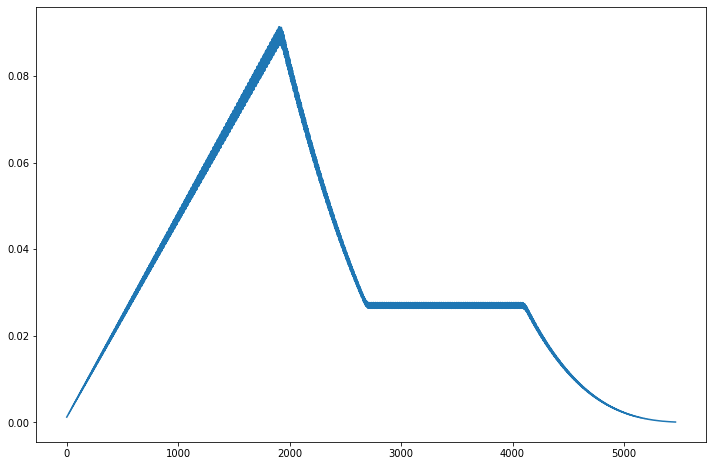

In [10]:
surge = surgepy.createSurge( 44100 )    
cg = surge.getControlGroup(srgco.cg_ENV)
aeg0Params = cg.getEntries()[0].getParams()

attack = aeg0Params[0]
decay = aeg0Params[2]
sustain = aeg0Params[4]
release = aeg0Params[5]

surge.setParamVal( attack, 0.5 )
surge.setParamVal( decay, 0.3 )
surge.setParamVal( sustain, 0.3 )
surge.setParamVal( release, 0.2 )

    
window = fourSecondsRMS( surge )
plt.plot( window )

## Setting and Querying Modulation

Surge is a powerful synth because of its flexible modulation. Almost all interesting
patches make extensive use of the modulation features. This python API allows you to
query and set up modulation using the same API that the UI uses when in modulation armed mode.

The three key APIs we have are getModSource, setModulation and getModulation. So lets
make an ADSR with an LFO wiggle, and the constants have ms_ constants defined

Modulation to osc0lev from lfo1 is:  0.10000000149011612


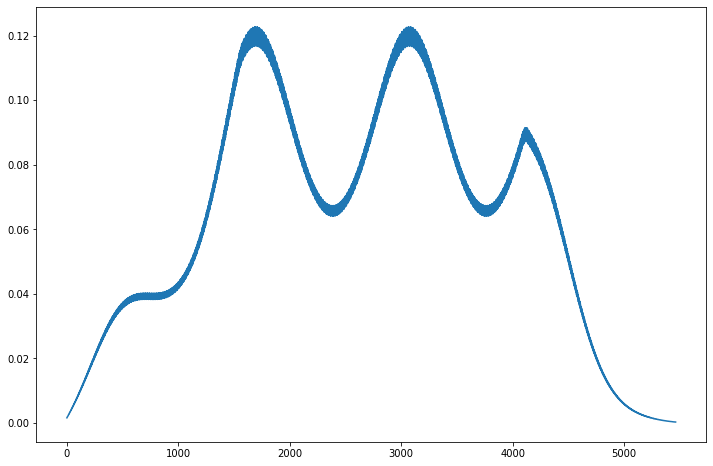

In [11]:
surge = surgepy.createSurge( 44100 )    

# This is the same as above
cg = surge.getControlGroup(srgco.cg_ENV)
aeg0Params = cg.getEntries()[0].getParams()
attack = aeg0Params[0]
release = aeg0Params[5]

surge.setParamVal( attack, 0.2 )
surge.setParamVal( release, 0.2 )

# But now lets assign LFO 1 to the mixer for OSC0
cg = surge.getControlGroup(srgco.cg_MIX)
osc0lev = cg.getEntries()[0].getParams()[0]
lfo1 = surge.getModSource(srgco.ms_lfo1)

surge.setModulation( osc0lev, lfo1, 0.1 )


window = fourSecondsRMS( surge )
plt.plot( window )
print( "Modulation to osc0lev from lfo1 is: ", surge.getModulation( osc0lev, lfo1 ))

# Interacting with Stored Patches

Surge allows you to interact with patches on the filesystem both for reading
and writing. This allows you to create a patch generator using the state manipulation
above. Moreover surge provides you with the location of the factory and user data areas.

*TODO* Error Reporting here is "weak". 

/Users/paul/Library/Application Support/Surge/


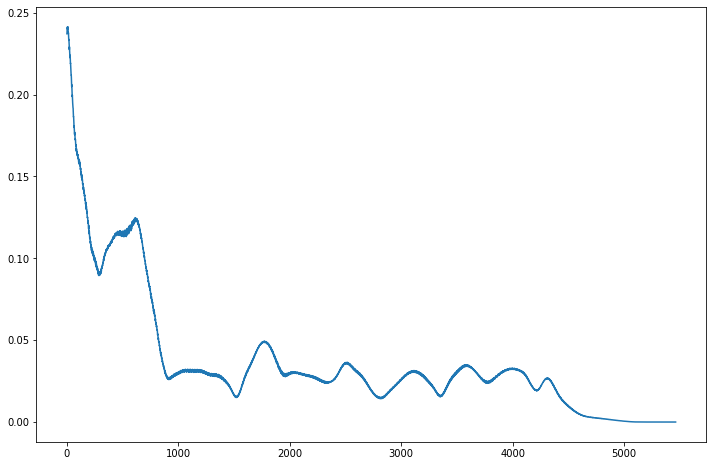

In [12]:
surge = surgepy.createSurge( 44100 )
fd = surge.getFactoryDataPath()
print( fd )

patch = fd + "/patches_factory/Keys/DX EP.fxp"
surge.loadPatch( patch )

window = fourSecondsRMS( surge )
plt.plot( window )

Similarly, we can save a patch to a file. Here we take the current surge with the DXEP
save it to a tmp file, then load it in a new surge and show that works since the before and after has the saw vs the dx envelope

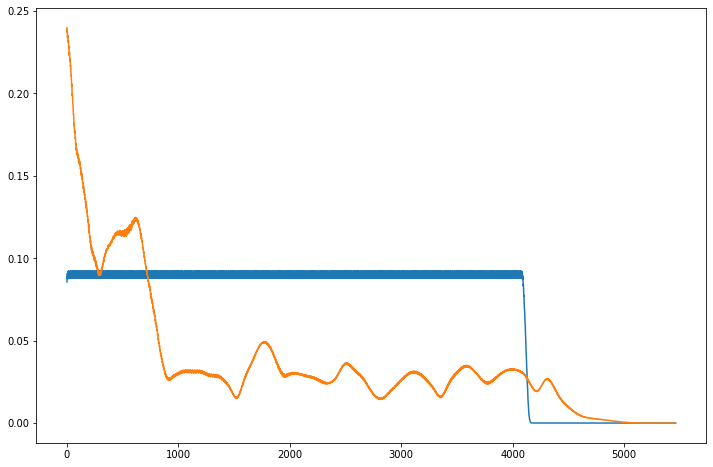

In [13]:
import tempfile

tfd = tempfile.gettempdir()
surge.savePatch( tfd + "/gen.fxp" )

newSurge = surgepy.createSurge(44100)
window = fourSecondsRMS( newSurge )
plt.plot( window )

newSurge.loadPatch( tfd + "/gen.fxp" )

window = fourSecondsRMS( newSurge )
plt.plot( window )

## Processing chunks

The default block size in surge (32) is very small compared to any musical length you may have
and so putting a process and copy loop in python is probably very inefficient.

In [14]:
surge = surgepy.createSurge(44100)
q = surge.createMultiblockStorage(500)
np.shape(q)

(2, 16000)

Load up the DX EP again and then play a couple of notes

In [ ]:
fd = surge.getFactoryDataPath()
print( fd )
patch = fd + "/patches_factory/Keys/DX EP.fxp"
surge.loadPatch( patch )

# Spool some blank
surge.processFor( 10 )

q = surge.createMultiblockStorage( 50 )
surge.playNote( 0, 60, 127, 0 )
surge.processCollecting( q )

# The multiblock can become an np array without a copy
a = np.array(q, copy = False )
plt.plot( a[0] )

In [16]:
np.shape(a)

(2, 1600)

In [17]:
a[0]

array([0.00173341, 0.03037926, 0.14839056, ..., 0.        , 0.        ,
       0.        ], dtype=float32)